<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement various autoencoder models and run them on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
!export CUDA_VISIBLE_DEVICES=5


In [2]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# # This link may break due to google changing how files are linked. You can manually download from https://drive.google.com/drive/folders/1BOLGo3CFDa_qJMLRgtTZ6zrAWezk9oJu?usp=sharing 
# !curl "https://drive.usercontent.google.com/download?id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF&confirm=xxx" -o hw2_data.zip
# !unzip -qq hw2_data.zip -d deepul/homeworks/hw2/data
# !pip install ./deepul
from deepul.hw2_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

In [3]:
import torch
import os

# Set the specific GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

Dataset 1


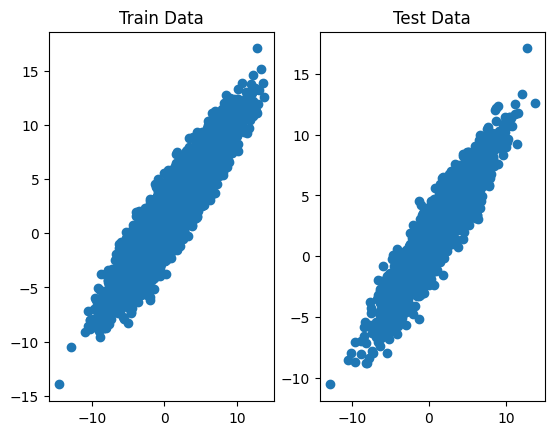

Dataset 2


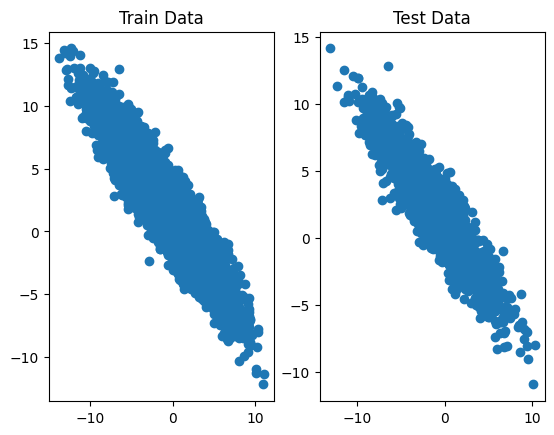

In [4]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-p(x|z)]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [5]:
# uncomment this code to fix the bug don't have dataset
# import torchvision
# import torchvision.transforms as transforms

# def get_svhn_dataset():
#   data_dir = get_data_dir(2)
#   train_dataset = torchvision.datasets.SVHN(root=data_dir, split="train", download=True, transform=transforms.ToTensor())
#   test_dataset = torchvision.datasets.SVHN(root=data_dir, split="test", download=True, transform=transforms.ToTensor())
#   data = {"train": train_dataset.data.transpose((0, 2, 3, 1)), "test": test_dataset.data.transpose(0, 2, 3, 1)}
#   with open(join(data_dir, "svhn.pkl"), "wb") as file:
#     pickle.dump(data, file)

# def get_cifar10_dataset():
#   data_dir = get_data_dir(2)
#   train_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transforms.ToTensor())
#   test_dataset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
#   data = {"train": train_dataset.data, "test": test_dataset.data}
#   with open(join(data_dir, "cifar10.pkl"), "wb") as file:
#     pickle.dump(data, file)

# get_svhn_dataset()
# get_cifar10_dataset()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

class VAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=2, hidden_dim=64):
        super(VAE, self).__init__()
        
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)  # Output both mu and logvar
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * input_dim)  # Output both mu and logvar
        )
    
    def encode(self, x):
        mu, logvar = self.encoder(x)
        logvar = torch.clamp(logvar, -5, 5)  # Prevent numerical issues
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        mu, logvar = self.decoder(z)
        logvar = torch.clamp(logvar, -5, 2)  # Prevent numerical issues
        return mu, logvar
    
    def forward(self, x):
        z_mu, z_logvar = self.encode(x)
        z = self.reparameterize(z_mu, z_logvar)
        x_mu, x_logvar = self.decode(z)
        return x_mu, x_logvar, z_mu, z_logvar
    
    def sample_prior(self, n_samples):
        device = next(self.parameters()).device
        z = torch.randn(n_samples, self.latent_dim, device=device)
        return z
    
    def generate_samples(self, n_samples, with_noise=True):
        self.eval()
        with torch.no_grad():
            z = self.sample_prior(n_samples)
            x_mu, x_logvar = self.decode(z)
            
            if with_noise:
                std = torch.exp(0.5 * x_logvar)
                eps = torch.randn_like(std)
                x = x_mu + eps * std
            else:
                x = x_mu
                
        return x.cpu().numpy()

def compute_loss(x, x_mu, x_logvar, z_mu, z_logvar):
    # Reconstruction loss
    reconstruction_loss = 0.5 * (
        torch.log(2 * torch.pi * torch.exp(x_logvar)) + 
        (x - x_mu)**2 / torch.exp(x_logvar)
    ).sum(dim=-1).mean()
    
    # KL divergence
    kl_loss = 0.5 * (
        torch.exp(z_logvar) + z_mu**2 - 1 - z_logvar
    ).sum(dim=-1).mean()
    
    elbo = reconstruction_loss + kl_loss
    return elbo, reconstruction_loss, kl_loss

def evaluate_model(model, data_loader, device):
    model.eval()
    total_elbo = 0
    total_recon = 0
    total_kl = 0
    n_batches = 0
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            x_mu, x_logvar, z_mu, z_logvar = model(x)
            elbo, recon, kl = compute_loss(x, x_mu, x_logvar, z_mu, z_logvar)
            
            total_elbo += elbo.item()
            total_recon += recon.item()
            total_kl += kl.item()
            n_batches += 1
    
    return total_elbo / n_batches, total_recon / n_batches, total_kl / n_batches

In [7]:
def q1(train_data, test_data, part, dset_id):
    # Simplified hyperparameters
    batch_size = 32
    learning_rate = 1e-4
    n_epochs = 60
    hidden_dim = 128
    latent_dim = 2
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Convert data to tensors
    train_tensor = torch.FloatTensor(train_data)
    test_tensor = torch.FloatTensor(test_data)
    
    # Create data loaders
    train_dataset = TensorDataset(train_tensor)
    test_dataset = TensorDataset(test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize simplified model
    model = VAE(input_dim=train_data.shape[1], latent_dim=latent_dim, hidden_dim=hidden_dim)
    model.to(device)
    
    # Simple optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Storage for training curves
    train_losses = []
    test_losses = []
    
    # Initial evaluation
    test_elbo, test_recon, test_kl = evaluate_model(model, test_loader, device)
    test_losses.append([test_elbo, test_recon, test_kl])
    
    print(f"Initial test - ELBO: {test_elbo:.4f}, Recon: {test_recon:.4f}, KL: {test_kl:.4f}")
    
    # Training loop
    model.train()
    for epoch in range(n_epochs):
        epoch_train_losses = []
        
        for batch_idx, batch in enumerate(train_loader):
            x = batch[0].to(device)
            
            # Forward pass
            x_mu, x_logvar, z_mu, z_logvar = model(x)
            
            # Compute loss
            elbo, recon_loss, kl_loss = compute_loss(x, x_mu, x_logvar, z_mu, z_logvar)
            
            # Backward pass
            optimizer.zero_grad()
            elbo.backward()
            optimizer.step()
            
            # Store training losses
            train_losses.append([elbo.item(), recon_loss.item(), kl_loss.item()])
            epoch_train_losses.append([elbo.item(), recon_loss.item(), kl_loss.item()])
        
        # Evaluate on test set
        test_elbo, test_recon, test_kl = evaluate_model(model, test_loader, device)
        test_losses.append([test_elbo, test_recon, test_kl])
        
        # Print progress
        if (epoch + 1) % 30 == 0:
            avg_train_elbo = np.mean([loss[0] for loss in epoch_train_losses])
            print(f"Epoch {epoch+1}/{n_epochs} - Train ELBO: {avg_train_elbo:.4f}, Test ELBO: {test_elbo:.4f}")
    
    # Final test performance
    final_test_elbo, final_test_recon, final_test_kl = test_losses[-1]
    print(f"\nFinal test performance:")
    print(f"ELBO: {final_test_elbo:.4f}")
    print(f"Reconstruction Loss: {final_test_recon:.4f}")
    print(f"KL Divergence: {final_test_kl:.4f}")
    
    # Generate samples
    samples_with_noise = model.generate_samples(1000, with_noise=True)
    samples_without_noise = model.generate_samples(1000, with_noise=False)
    
    # Convert to numpy arrays
    train_losses_array = np.array(train_losses)
    test_losses_array = np.array(test_losses)
    
    return train_losses_array, test_losses_array, samples_with_noise, samples_without_noise

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

In [8]:
# q1_save_results('a', 1, q1)

In [9]:
# q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


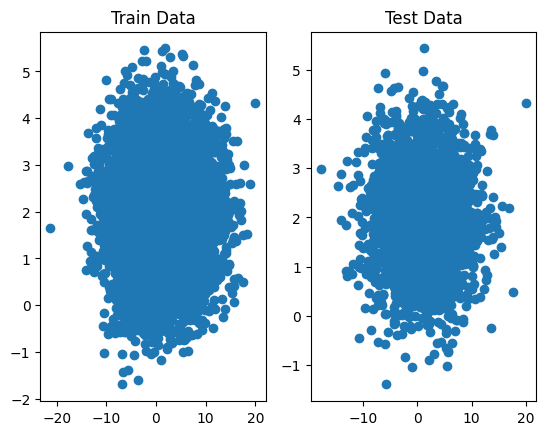

Dataset 2


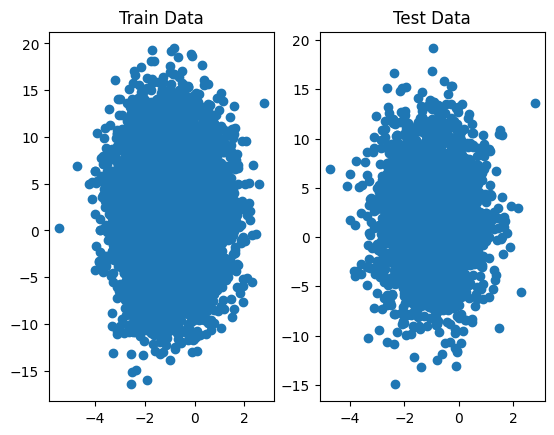

In [10]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

In [11]:
# q1_save_results('b', 1, q1)

In [12]:
# q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

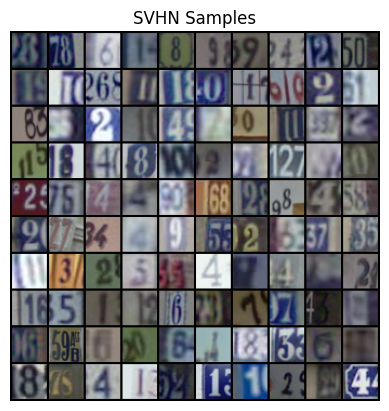

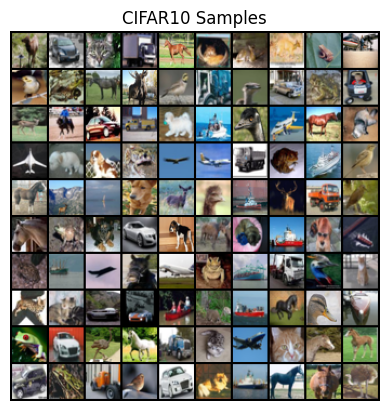

In [13]:
visualize_svhn()

visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu()
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten() # 16
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


class image_VAE(nn.Module):
    def __init__(self, latent_dim, image_shape):
        super(image_VAE, self).__init__()

        self.latent_dim = latent_dim
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        c, h, w = image_shape
        assert h == 32 and w == 32, "image shape must be 32x32"  
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=3, stride=1, padding=1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),  # 8x8
            nn.ReLU(), 
            nn.Conv2d(128, 256, 3, 2, 1),  # 4x4,
            nn.ReLU(),  
            nn.Flatten(),  
            nn.Linear(4*4*256, 2 * latent_dim)  # Output both mu and logvar
        )
        
        # Decoder network - Fixed: removed duplicate definition and syntax errors
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 4*4*128), 
            nn.ReLU(), 
            nn.Unflatten(1, (128, 4, 4)),  # Fixed: torch.reshape -> nn.Unflatten for proper reshaping
            nn.ConvTranspose2d(128, 128, 4, 2, 1),  # 8x8
            nn.ReLU(),  
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 16x16 
            nn.ReLU(),  
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 32x32
            nn.ReLU(), 
            nn.Conv2d(32, 3, 3, 1, 1)  # Final output layer
        )
    
    def encode(self, x): 
        encoded = self.encoder(x)
        mu, logvar = torch.chunk(encoded, 2, dim=1)  # Split into mu and logvar
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick for VAE"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):  
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar
    
    def reconstruct_image(self, x):
        """Reconstruct images from input"""
        self.eval()
        with torch.no_grad():
            mu, logvar = self.encode(x)
            z = self.reparameterize(mu, logvar)
            recon_x = self.decode(z)
        return recon_x
        
    def generate_samples(self, n_samples):
        """Generate samples from the VAE"""
        self.eval()
        samples = []
        with torch.no_grad():
            for _ in range(n_samples):
                z = torch.randn(1, self.latent_dim, device=self.device)
                sample = self.decode(z).cpu()
                samples.append(sample)
        return torch.cat(samples, dim=0)  # Fixed: return tensor instead of calling .numpy()

def compute_loss(x, recon_x, mu, logvar):
    """Compute VAE loss: reconstruction + KL divergence"""
    # Reconstruction loss - MSE averaged over batch, summed over features
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    
    # KL divergence - analytical form for diagonal Gaussian
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    # Total ELBO (negative)
    elbo = recon_loss + kl_loss
    return elbo, recon_loss, kl_loss

def evaluate_model(model, data_loader):
    """Evaluate model on a dataset"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    total_elbo = 0
    total_recon = 0
    total_kl = 0
    n_batches = 0
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            recon_x, mu, logvar = model(x)  # Fixed: updated to match new forward signature
            elbo, recon, kl = compute_loss(x, recon_x, mu, logvar)  # Fixed: updated function call
            
            total_elbo += elbo.item()
            total_recon += recon.item()
            total_kl += kl.item()
            n_batches += 1
    
    return total_elbo / n_batches, total_recon / n_batches, total_kl / n_batches 

def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    # Hyperparameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 128  
    learning_rate = 1e-3  
    n_epochs = 50  
    latent_dim = 16
    
    # Preprocess data: normalize to [0,1] and transpose to (N,C,H,W)
    train_tensor = torch.FloatTensor(train_data).permute(0, 3, 1, 2) / 255.0
    test_tensor = torch.FloatTensor(test_data).permute(0, 3, 1, 2) / 255.0
    
    train_dataset = TensorDataset(train_tensor)
    test_dataset = TensorDataset(test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    image_shape = (3, 32, 32)  # Fixed: use (C,H,W) format
    model = image_VAE(latent_dim, image_shape).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    # Initial evaluation
    test_elbo, test_recon, test_kl = evaluate_model(model, test_loader)
    test_losses.append([test_elbo, test_recon, test_kl])
    print(f"Initial test - ELBO: {test_elbo:.4f}, Recon: {test_recon:.4f}, KL: {test_kl:.4f}")
    
    # Training loop
    model.train()
    for epoch in range(n_epochs):
        epoch_train_losses = []
        for batch_idx, batch in enumerate(train_loader):
            x = batch[0].to(device)   # we don't have label 
            
            optimizer.zero_grad() 
            recon_x, mu, logvar = model(x) 
            elbo, recon_loss, kl_loss = compute_loss(x, recon_x, mu, logvar)
            
            elbo.backward()
            optimizer.step()
            
            train_losses.append([elbo.item(), recon_loss.item(), kl_loss.item()])
            epoch_train_losses.append([elbo.item(), recon_loss.item(), kl_loss.item()])
        
        # Evaluate on test set after each epoch
        test_elbo, test_recon_loss, test_kl_loss = evaluate_model(model, test_loader)
        test_losses.append([test_elbo, test_recon_loss, test_kl_loss])
        
        # Print progress
        if (epoch + 1) % 10 == 0:  
            avg_train_elbo = np.mean([loss[0] for loss in epoch_train_losses])
            print(f"Epoch {epoch+1}/{n_epochs} - Train ELBO: {avg_train_elbo:.4f}, Test ELBO: {test_elbo:.4f}")
    
    # Generate 100 samples
    samples = model.generate_samples(100)
    samples = (samples.permute(0, 2, 3, 1) * 255).clamp(0, 255).byte().numpy()  # Convert back to uint8
    
    # Generate 50 reconstruction pairs (100 images total)
    model.eval()
    with torch.no_grad():
        # Get 50 test images
        test_images = test_tensor[:50].to(device)
        reconstructions = model.reconstruct_image(test_images)
        
        # Interleave original and reconstructed images
        recon_pairs = []
        for i in range(50):
            # Original image
            orig = (test_images[i].cpu().permute(1, 2, 0) * 255).clamp(0, 255).byte().numpy()
            recon_pairs.append(orig)
            # Reconstructed image
            recon = (reconstructions[i].cpu().permute(1, 2, 0) * 255).clamp(0, 255).byte().numpy()
            recon_pairs.append(recon)
        
        recon_pairs = np.array(recon_pairs)
    
    # Generate 10 interpolations of length 10 (100 images total)
    model.eval()
    interpolations = []
    with torch.no_grad():
        for i in range(10):
            # Get two random test images
            idx1, idx2 = np.random.choice(len(test_tensor), 2, replace=False)
            img1, img2 = test_tensor[idx1:idx1+1].to(device), test_tensor[idx2:idx2+1].to(device)
            
            # Encode to latent space
            mu1, logvar1 = model.encode(img1)
            mu2, logvar2 = model.encode(img2)
            z1 = model.reparameterize(mu1, logvar1)
            z2 = model.reparameterize(mu2, logvar2)
            
            # Interpolate in latent space
            for j in range(10):
                alpha = j / 9.0
                z_interp = (1 - alpha) * z1 + alpha * z2
                img_interp = model.decode(z_interp)
                img_interp = (img_interp.cpu().permute(0, 2, 3, 1) * 255).clamp(0, 255).byte().numpy()[0]
                interpolations.append(img_interp)
    
    interpolations = np.array(interpolations)
    
    return (np.array(train_losses), np.array(test_losses), 
            samples, recon_pairs, interpolations)

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

In [15]:
# q2_save_results('a', 1, q2_a)

In [16]:
# q2_save_results('a', 2, q2_a)

## Part (b) Hierarchical VAE [20pts]

In this part, we will explore a simplified version of the hierarchical VAE described in [NVAE](https://arxiv.org/pdf/2007.03898.pdf). We will not implement the full NVAE, but rather use some ideas from the paper to explore how to learn a prior distribution p(z).

Implement a hierarchical VAE that follows the following structure.
* $z1$ is a 2x2x12 latent vector where p(z1) is the unit Gaussian.
    * Learn the approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix. I.e., same as a normal VAE, but use a matrix latent rather than a vector. Each dimension is independent.
* $z2$ is a 2x2x12 latent vector.
    * $p_\theta(z2|z1)$ is learned, and implemented as a neural network that parameterizes mean (and log std, optionally).
    * $q_\theta(z2|z1,x)$ is also learned. Implement this as a Residual Normal [see NVAE] over the prior $p_\theta(z2|z1)$.
* The decoder should be a function of $z2$ only.

Some helpful hints:
* Two KL losses should be calculated. The first should match $q_\theta(z|x)$ to the unit Gaussian. The second should match $q_\theta(z2|z1,x)$ and $p_\theta(z2|z1)$, and be taken with respect to $q$.
* When calculating the second KL term, utilize the analytic form for the residual normal. When $q_\theta(z2|z1,x) = N(z2; \mu_\theta(z1) + \Delta \mu_\theta(z1,x), \Sigma_\theta(z1)) * \Delta \Sigma_\theta(z1,x))$, use the following form: `kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5`
* When calculating KL, remember to sum over the dimensions of the latent variable before taking the mean over batch.
* For the prior $p_\theta(z2|z1)$, fix standard deviation to be 1. Learn only the mean. This will help with stability in training.

The following network structures may be useful:
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
        nn.Conv2d(3 + 12, 32, 3, padding=1), # [32, 32, 32]
        LayerNorm(32),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1), # [64, 16, 16]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 8, 8]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 4, 4]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, 3, stride=2, padding=1), # [64, 2, 2]
        LayerNorm(64),
        nn.ReLU(),
        nn.Conv2d(64, 12*2, 3, padding=1), # [12*2, 2, 2]
We assume encoder networks are of the form p(z'|z,x).
When learning q(z1), an x of all zeros can be used as input.
Upscale z with nearest-neighbor projection before concatenating with x.


Decoder
        nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
        nn.ReLU(),
        nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
```


**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. 10 interpolations of 10 images from your trained VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [17]:
class CustomLayerNorm(nn.Module):
    """
    Custom LayerNorm that can handle 4D tensors (batch, channels, height, width)
    Normalizes over the channel dimension while preserving spatial dimensions.
    """
    def __init__(self, normalized_shape, eps=1e-5, elementwise_affine=True):
        super(CustomLayerNorm, self).__init__()
        
        if isinstance(normalized_shape, int):
            normalized_shape = (normalized_shape,)
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.ones(normalized_shape))
            self.bias = nn.Parameter(torch.zeros(normalized_shape))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
    
    def forward(self, input):
        # Handle different input dimensions
        if input.dim() == 2:
            # Standard case: [batch, features]
            return F.layer_norm(input, self.normalized_shape, self.weight, self.bias, self.eps)
        
        elif input.dim() == 4:
            # 4D case: [batch, channels, height, width]
            batch_size, channels, height, width = input.shape
            
            # Ensure the normalized_shape matches the channel dimension
            if len(self.normalized_shape) == 1 and self.normalized_shape[0] == channels:
                # Reshape to [batch * height * width, channels]
                input_reshaped = input.permute(0, 2, 3, 1).contiguous()  # [batch, height, width, channels]
                input_reshaped = input_reshaped.view(-1, channels)  # [batch*height*width, channels]
                
                # Apply LayerNorm
                output = F.layer_norm(input_reshaped, self.normalized_shape, self.weight, self.bias, self.eps)
                
                # Reshape back to [batch, channels, height, width]
                output = output.view(batch_size, height, width, channels)  # [batch, height, width, channels]
                output = output.permute(0, 3, 1, 2)  # [batch, channels, height, width]
                
                return output
            else:
                raise ValueError(f"For 4D input with shape {input.shape}, normalized_shape should be ({channels},) but got {self.normalized_shape}")
        
        elif input.dim() == 3:
            # 3D case: [batch, seq_len, features] - standard LayerNorm
            return F.layer_norm(input, self.normalized_shape, self.weight, self.bias, self.eps)
        
        else:
            raise ValueError(f"CustomLayerNorm supports 2D, 3D, and 4D inputs, but got {input.dim()}D input with shape {input.shape}")


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NVAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3+12 , 32, 3 , padding = 1 ), # [32,32,32]
            CustomLayerNorm(32),
            nn.ReLU(),
            nn.Conv2d(32 , 64, 3 , stride = 2 , padding =1 ), # [64,16,16],
            CustomLayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride = 2 , padding =1 ), # [64,8,8]
            CustomLayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride =2 , padding =1), #[64,4,4]
            CustomLayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride =2 , padding =1), #[64,2,2]
            CustomLayerNorm(64),
            nn.ReLU(),
            nn.Conv2d(64, 12*2 , 3 , padding =1 ), # [12 *2 , 2, 2]
        )
        self.prior_network = nn.Sequential(
            nn.Conv2d(12, 32, 3 , padding =1), #[32,2,2],
            nn.ReLU(),
            nn.Conv2d(32, 12, 3, padding =1), #[12,2,2],
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(12, 64, 3, padding=1), # [64, 2, 2]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, stride=2, padding=1), # [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1), # [3, 32, 32]
        )
        
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def encode_z1(self,x):
        x_zeros = torch.zeros(x.size(0), 15, 32, 32, device=self.device)
        output = self.encoder(x_zeros)
        z1_mu , z1_logvar = torch.chunk(output, 2, dim = 1)
        return z1_mu, z1_logvar
    
    def encode_z2(self, z1_upsample, x):
        output = self.encoder(torch.cat([z1_upsample, x], dim = 1))
        z2_residual_mu , z2_residual_logstd = torch.chunk(output, 2, dim = 1)
        return z2_residual_mu, z2_residual_logstd
    

    def decode(self, z2):  
        return self.decoder(z2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self,x):
        # encode z1
        z1_mu, z1_logvar = self.encode_z1(x)
        z1 = self.reparameterize(z1_mu, z1_logvar)
        
        # get miu_2, logvar_2
        z2_mu = self.prior_network(z1)  
        # logvar_2 = 1
        
        # get residual z2
        z1_upsample = F.interpolate(z1, size = (32,32), mode = 'nearest')
        z2_residual_mu, z2_residual_logstd = self.encode_z2(z1_upsample, x)


        z2 = self.reparameterize(z2_mu + z2_residual_mu , 2 * z2_residual_logstd)

        x_recon = self.decode(z2)
        return x_recon, z1_mu, z1_logvar, z2_residual_mu, z2_residual_logstd
    
    def generate_samples(self, n_samples):
        """Generate samples from the VAE"""
        self.eval()
        samples = []
        with torch.no_grad():
            for _ in range(n_samples):
                z1 = torch.randn(1, 12, 2, 2, device=self.device)
                z2_mu_prior = self.prior_network(z1)
                
                z2 = torch.randn_like(z2_mu_prior, device=self.device) + z2_mu_prior
                
                sample = self.decode(z2).cpu()
                samples.append(sample)
        return torch.cat(samples, dim=0)  # Fixed: return tensor instead of calling .numpy()

    def encode_for_interpolation(self, x):
        
        self.eval()
        with torch.no_grad():
            z1_mu, z1_logvar = self.encode_z1(x)
            z1 = self.reparameterize(z1_mu, z1_logvar)
            z2_mu = self.prior_network(z1)
            z1_upsample = F.interpolate(z1, size = (32,32), mode = 'nearest')
            z2_residual_mu, z2_residual_logstd = self.encode_z2(z1_upsample, x)
            
            z2 = self.reparameterize(z2_mu + z2_residual_mu , 2 * z2_residual_logstd)
            return z2

            
def compute_loss(x, recon_x, z1_mu, z1_logvar, z2_residual_mu, z2_residual_logstd ):
    """Compute VAE loss: reconstruction + KL divergence"""
    # Reconstruction loss - MSE averaged over batch, summed over features
    batch_size = x.size(0)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum') / batch_size
    
    # KL divergence - analytical form for diagonal Gaussian
    kl_z1 = -0.5 * torch.sum(1 + z1_logvar - z1_mu.pow(2) - z1_logvar.exp()) / batch_size
    
    kl_z2 = -z2_residual_logstd - 0.5 + (torch.exp(2 * z2_residual_logstd) + z2_residual_mu ** 2) * 0.5
    kl_z2 = torch.sum(kl_z2) / batch_size
    
    kl_loss = kl_z1 + kl_z2
    # Total ELBO (negative)
    elbo = recon_loss + kl_loss
    return elbo, recon_loss, kl_loss

def evaluate_model(model, data_loader):
    """Evaluate model on a dataset"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    total_elbo = 0
    total_recon = 0
    total_kl = 0
    n_batches = 0
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            recon_x, z1_mu, z1_logvar, z2_delta_mu, z2_delta_logvar = model(x)  
            elbo, recon, kl = compute_loss(x, recon_x, z1_mu, z1_logvar, z2_delta_mu, z2_delta_logvar)  # Fixed: updated function call
            
            total_elbo += elbo.item()
            total_recon += recon.item()
            total_kl += kl.item()
            n_batches += 1
    
    return total_elbo / n_batches, total_recon / n_batches, total_kl / n_batches 

In [19]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    # Hyperparameters
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 128  
    learning_rate = 1e-3  
    n_epochs = 50
    
    # Preprocess data: normalize to [0,1] and transpose to (N,C,H,W)
    train_tensor = torch.FloatTensor(train_data).permute(0, 3, 1, 2) / 255.0
    test_tensor = torch.FloatTensor(test_data).permute(0, 3, 1, 2) / 255.0
    
    train_dataset = TensorDataset(train_tensor)
    test_dataset = TensorDataset(test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model
    # image_shape = (3, 32, 32)  # Fixed: use (C,H,W) format
    model = NVAE().to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []
    
    # Initial evaluation
    test_elbo, test_recon, test_kl = evaluate_model(model, test_loader)
    test_losses.append([test_elbo, test_recon, test_kl])
    print(f"Initial test - ELBO: {test_elbo:.4f}, Recon: {test_recon:.4f}, KL: {test_kl:.4f}")
    
    # Training loop
    model.train()
    for epoch in range(n_epochs):
        epoch_train_losses = []
        for batch_idx, batch in enumerate(train_loader):
            x = batch[0].to(device)   # we don't have label 
            
            optimizer.zero_grad() 
            recon_x, z1_mu, z1_logvar, z2_delta_mu, z2_delta_logvar = model(x) 
            elbo, recon_loss, kl_loss = compute_loss(x, recon_x, z1_mu, z1_logvar, z2_delta_mu, z2_delta_logvar)
            
            elbo.backward()
            optimizer.step()
            
            train_losses.append([elbo.item(), recon_loss.item(), kl_loss.item()])
            epoch_train_losses.append([elbo.item(), recon_loss.item(), kl_loss.item()])
        
        # Evaluate on test set after each epoch
        test_elbo, test_recon_loss, test_kl_loss = evaluate_model(model, test_loader)
        test_losses.append([test_elbo, test_recon_loss, test_kl_loss])
        
        # Print progress
        if (epoch + 1) % 1 == 0:  
            avg_train_elbo = np.mean([loss[0] for loss in epoch_train_losses])
            print(f"Epoch {epoch+1}/{n_epochs} - Train ELBO: {avg_train_elbo:.4f}, Test ELBO: {test_elbo:.4f}")
    
    # Generate 100 samples
    samples = model.generate_samples(100)
    samples = (samples.permute(0, 2, 3, 1) * 255).clamp(0, 255).byte().numpy()  # Convert back to uint8
    
    # Generate 50 reconstruction pairs (100 images total)
    model.eval()
    with torch.no_grad():
        # Get 50 test images
        test_images = test_tensor[:50].to(device)
        recon_x, _, _, _, _ = model(test_images)
        
        # Interleave original and reconstructed images
        recon_pairs = []
        for i in range(50):
            # Original image
            orig = (test_images[i].cpu().permute(1, 2, 0) * 255).clamp(0, 255).byte().numpy()
            recon_pairs.append(orig)
            # Reconstructed image
            recon = (recon_x[i].cpu().permute(1, 2, 0) * 255).clamp(0, 255).byte().numpy()
            recon_pairs.append(recon)
        
        recon_pairs = np.array(recon_pairs)
    
    # Generate 10 interpolations of length 10 (100 images total)
    model.eval()
    interpolations = []
    with torch.no_grad():
        for i in range(10):
            # Get two random test images
            idx1, idx2 = np.random.choice(len(test_tensor), 2, replace=False)
            img1, img2 = test_tensor[idx1:idx1+1].to(device), test_tensor[idx2:idx2+1].to(device)
            
            # Encode to latent space
            z2_1 = model.encode_for_interpolation(img1)
            z2_2 = model.encode_for_interpolation(img2)
            
            # Interpolate in latent space
            for j in range(10):
                alpha = j / 9.0
                z_interp = (1 - alpha) * z2_1 + alpha * z2_2
                img_interp = model.decode(z_interp)
                img_interp = (img_interp.cpu().permute(0, 2, 3, 1) * 255).clamp(0, 255).byte().numpy()[0]
                interpolations.append(img_interp)
    
    interpolations = np.array(interpolations)
    
    return (np.array(train_losses), np.array(test_losses), 
            samples, recon_pairs, interpolations)

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

Initial test - ELBO: 813.0577, Recon: 804.1094, KL: 8.9483
Epoch 1/50 - Train ELBO: 87.6827, Test ELBO: 62.9194
Epoch 2/50 - Train ELBO: 49.6232, Test ELBO: 50.6558
Epoch 3/50 - Train ELBO: 44.0034, Test ELBO: 46.4108
Epoch 4/50 - Train ELBO: 41.5957, Test ELBO: 45.0214
Epoch 5/50 - Train ELBO: 39.6856, Test ELBO: 43.2608
Epoch 6/50 - Train ELBO: 38.4422, Test ELBO: 41.8083
Epoch 7/50 - Train ELBO: 37.7487, Test ELBO: 40.1949
Epoch 8/50 - Train ELBO: 37.1283, Test ELBO: 39.7636
Epoch 9/50 - Train ELBO: 36.8933, Test ELBO: 39.3702
Epoch 10/50 - Train ELBO: 36.6728, Test ELBO: 39.0759
Epoch 11/50 - Train ELBO: 36.5447, Test ELBO: 39.1704
Epoch 12/50 - Train ELBO: 36.1985, Test ELBO: 39.3637
Epoch 13/50 - Train ELBO: 36.0672, Test ELBO: 38.3602
Epoch 14/50 - Train ELBO: 35.9857, Test ELBO: 38.4813
Epoch 15/50 - Train ELBO: 35.8266, Test ELBO: 38.0173
Epoch 16/50 - Train ELBO: 35.6356, Test ELBO: 38.1761
Epoch 17/50 - Train ELBO: 35.6139, Test ELBO: 37.6425
Epoch 18/50 - Train ELBO: 35.516

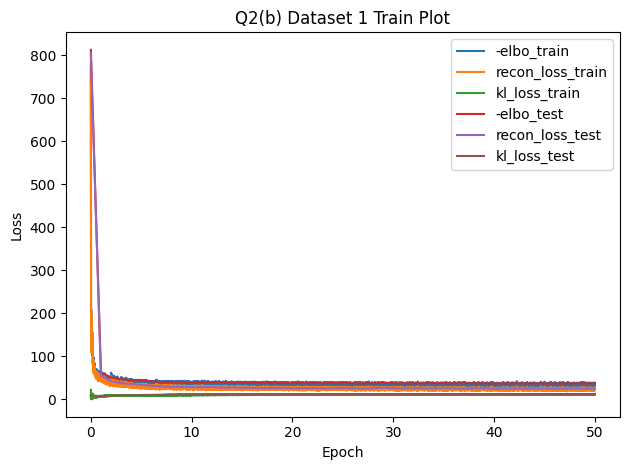

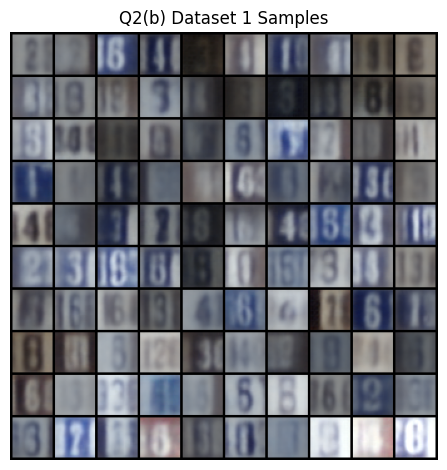

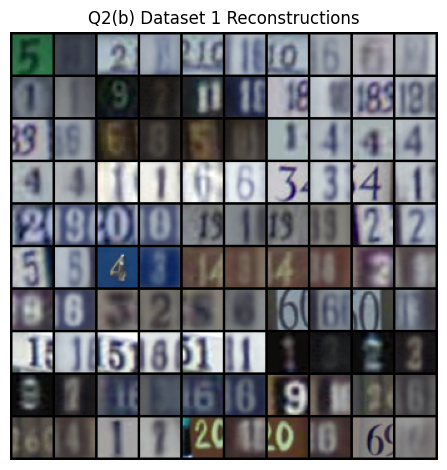

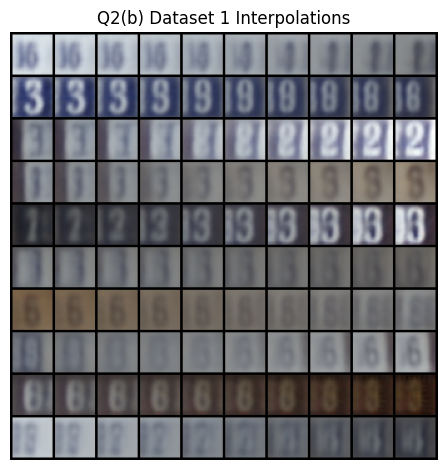

In [20]:
q2_save_results('b', 1, q2_b)

Initial test - ELBO: 971.3365, Recon: 961.7384, KL: 9.5982
Epoch 1/50 - Train ELBO: 185.5464, Test ELBO: 116.4194
Epoch 2/50 - Train ELBO: 104.4022, Test ELBO: 97.4818
Epoch 3/50 - Train ELBO: 94.7426, Test ELBO: 92.9203
Epoch 4/50 - Train ELBO: 91.0096, Test ELBO: 90.1839
Epoch 5/50 - Train ELBO: 89.2497, Test ELBO: 88.2220
Epoch 6/50 - Train ELBO: 87.3221, Test ELBO: 85.7719
Epoch 7/50 - Train ELBO: 84.3285, Test ELBO: 84.0162
Epoch 8/50 - Train ELBO: 81.8526, Test ELBO: 82.0246
Epoch 9/50 - Train ELBO: 80.6823, Test ELBO: 80.6377
Epoch 10/50 - Train ELBO: 79.9416, Test ELBO: 80.3441
Epoch 11/50 - Train ELBO: 79.3751, Test ELBO: 79.9810
Epoch 12/50 - Train ELBO: 79.0560, Test ELBO: 78.8002
Epoch 13/50 - Train ELBO: 78.6181, Test ELBO: 78.3109
Epoch 14/50 - Train ELBO: 78.2963, Test ELBO: 78.5360
Epoch 15/50 - Train ELBO: 77.9340, Test ELBO: 77.6702
Epoch 16/50 - Train ELBO: 77.7129, Test ELBO: 77.9488
Epoch 17/50 - Train ELBO: 77.5338, Test ELBO: 77.6923
Epoch 18/50 - Train ELBO: 77.

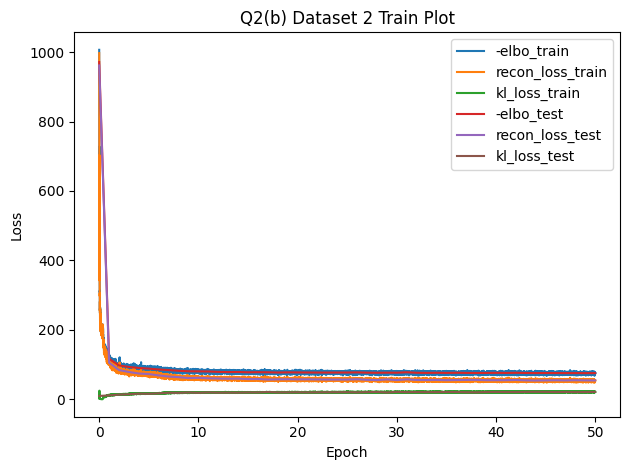

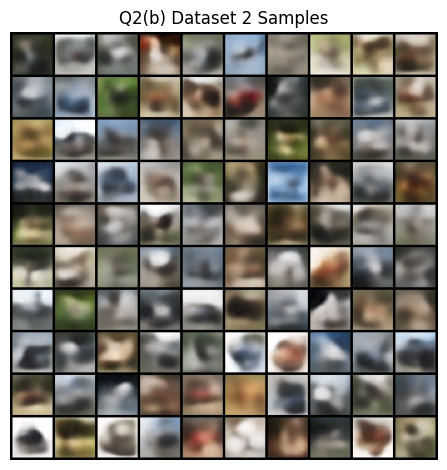

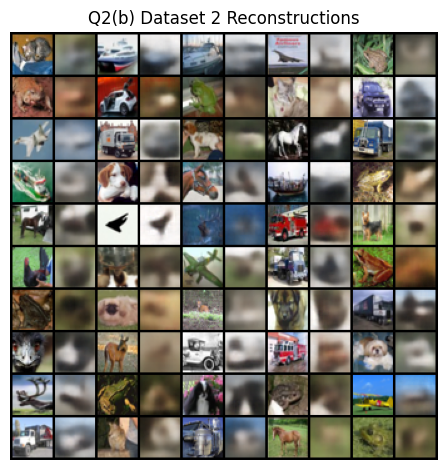

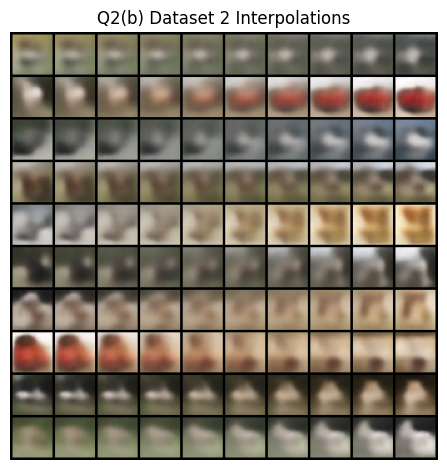

In [21]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder):
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a Transformer prior on the categorical latents in order to sample. Feel free to use your implementation for HW1! You should flatten the VQ-VAE tokens into a [H x W] sequence, and use a start token.

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and Transformer prior**. Code is provided that automatically plots the training curves.
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and Transformer prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [22]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        """
        q: (batch_size, n_heads, seq_len, head_size)
        k: (batch_size, n_heads, seq_len, head_size)
        v: (batch_size, n_heads, seq_len, head_size)
        """
        d_k = q.shape[-1]
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)  # (batch_size, n_heads, seq_len, seq_len)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)  # (batch_size, n_heads, seq_len, seq_len)
        attention_weights = self.dropout(attention_weights)  # (batch_size, n_heads, seq_len, seq_len)

        output = torch.matmul(attention_weights, v)  # (batch_size, n_heads, seq_len, head_size)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.0, cache=False):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.use_cache = cache

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.attention = ScaledDotProductAttention(dropout=dropout)
        self.cached_k = None
        self.cached_v = None

    def split_heads(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        return x.view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_size)
    
    def combine_heads(self, x):
        """
        x: (batch_size, n_heads, seq_len, head_size)
        """
        batch_size, n_heads, seq_len, head_size = x.shape
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)  # (batch_size, seq_len, d_model)
    
    def forward(self, x, mask=None, use_cache=False, past_key_values=None):
        batch_size, seq_len, d_model = x.shape
        if past_key_values is not None:
            self.cached_k, self.cached_v = past_key_values
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, head_size)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        # Use KV cache if enabled
        if use_cache and self.cached_k is not None and self.cached_v is not None:
            # Concatenate current k, v with cached k, v
            k = torch.cat([self.cached_k, k], dim=2)
            v = torch.cat([self.cached_v, v], dim=2)


            self.cached_k = k
            self.cached_v = v
        
        # Create causal mask if needed
        if mask is None:
            # If using cache, adjust mask to account for the full sequence length
            full_seq_len = k.size(2)
            # For cached version, we need to adjust the mask to allow attention to all past tokens
            if use_cache and self.cached_k is not None:
                # Create a mask where current tokens can attend to all previous tokens
                # Current sequence position is at seq_len
                seq_position = seq_len
                # Create a mask that allows each token to see itself and all previous tokens
                mask = torch.ones(seq_len, full_seq_len).to(x.device)
                # Make it causal by setting future positions to 0
                mask[:, seq_position:] = 0
            else:
                # Standard causal mask for the full sequence
                mask = torch.tril(torch.ones(full_seq_len, full_seq_len)).to(x.device)
            
            mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

        # Use the attention module directly
        output = self.attention(q, k, v, mask)  # (batch_size, n_heads, seq_len, head_size)
        
        # Combine heads
        output = self.combine_heads(output)  # (batch_size, seq_len, d_model)
        past_key_values = (k, v)
        if use_cache:
            return self.dropout(self.out(output)) , past_key_values
        else:
            return self.dropout(self.out(output))
    
    def clear_cache(self):
        self.cached_k = None
        self.cached_v = None
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, use_cache=False):
        super().__init__()
        self.masked_mha = MultiHeadAttention(d_model, n_heads, dropout, cache=use_cache)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),  
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, use_cache=False, past_key_values=None):

        # Self-attention with residual connection and layer normalization
        residual = x
        x = self.layer_norm1(x)  # Pre-norm architecture
        if use_cache and past_key_values is not None:
            x, past_key_values = self.masked_mha(x, use_cache=use_cache, past_key_values=past_key_values)
        else:
            x = self.masked_mha(x)
            
        x = residual + x  # Residual connection
        
        # Feed forward with residual connection and layer normalization
        residual = x
        x = self.layer_norm2(x)  # Pre-norm architecture
        x = self.feed_forward(x)
        x = residual + x  # Residual connection
        if use_cache:
            return x , past_key_values
        else:
            return x
    
    def clear_cache(self):
        self.masked_mha.clear_cache()

class iGPT(nn.Module):
    def __init__(self, vocab_size, context_length, d_model, n_heads, n_layers, dropout=0.1, use_cache=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.d_model = d_model
        self.n_heads = n_heads  
        self.n_layers = n_layers
        self.dropout = dropout
        self.use_cache = use_cache
        
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional embedding (learned, as per iGPT specs)
        self.position_embedding = nn.Embedding(context_length, d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Stack of decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, dropout, use_cache=use_cache) 
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x, past_key_values=None, use_cache=False):
        # x shape: (batch_size, seq_len)
        batch_size, seq_len = x.shape
        device = x.device
        
        # Create position indices
        positions = torch.arange(0, seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)
        
        # Get embeddings
        token_emb = self.token_embedding(x)  # (batch_size, seq_len, d_model)
        pos_emb = self.position_embedding(positions)  # (batch_size, seq_len, d_model)
        
        # Combine embeddings
        x = token_emb + pos_emb  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        
        # Apply decoder layers
        past_key_values = None
        for layer in self.decoder_layers:
            if use_cache:
                x, past_key_values = layer(x, use_cache=use_cache, past_key_values=past_key_values)
            else:
                x = layer(x)
        
        # Apply final layer norm
        x = self.layer_norm(x)  # (batch_size, seq_len, d_model)
        
        # Project to vocabulary
        logits = self.output_projection(x)  # (batch_size, seq_len, vocab_size)
        if use_cache:
            return logits, past_key_values
        else:
            return logits
    
    def clear_cache(self):
        for layer in self.decoder_layers:
            layer.clear_cache()

In [23]:
class residual(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.residual_block = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1, 1, 0)
        )
        
    def forward(self, x):
        return x + self.residual_block(x)
    
class VQVAE(nn.Module):
    def __init__(self, dim,K,D ):
        super().__init__()
        assert dim == D, f"Encoder output dim ({dim}) must match codebook dim ({D})"
        self.encoder_residual_1= residual(dim)
        self.encoder_residual_2= residual(dim)
        
        self.decoder_residual_1= residual(dim)
        self.decoder_residual_2= residual(dim)
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, dim, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, kernel_size=4, stride=2, padding=1),  # 8*8
            self.encoder_residual_1,
            self.encoder_residual_2,
        )
        
        self.decoder = nn.Sequential(
            self.decoder_residual_1,
            self.decoder_residual_2,
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.ConvTranspose2d(dim,dim,4,2,1), # 16*16
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.ConvTranspose2d(dim,3,4,2,1), # 32*32
        )
        
        self.codebook = nn.Embedding(K,D)
        nn.init.uniform_(self.codebook.weight, -1/K, 1/K)
    def encode(self,x):
        z_e = self.encoder(x)
        batch_size, channels, height, width = z_e.shape
        z_e_flat = z_e.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]
        z_e_flat = z_e_flat.view(-1, channels)  # [B*H*W, C]
        
        
        distances = torch.sum((z_e_flat.unsqueeze(1) - self.codebook.weight.unsqueeze(0))**2, dim=-1) 
        # z_e_flat -> [B*H*W, C] -> [B*H*W,1,  C]
        # self.codebook.weight.unsqueeze(0) -> [K, D] -> [1, K, D]
        # distances -> [B*H*W, K]
        

        k = torch.argmin(distances, dim=-1)  # [B*H*W]
        # k [B*H*W] -> [B*H*W, 1]
        z_q_flat = self.codebook(k)  # [B*H*W, D]
        z_q = z_q_flat.view(batch_size, height, width, -1).permute(0, 3, 1, 2).contiguous()  # Back to [B, C, H, W]
        
        z_q = z_e + (z_q - z_e).detach() # Straight-through estimator
        return z_e, z_q
        
    def decode(self, z_q):
        x_recon = self.decoder(z_q)
        return x_recon
    
    def forward(self, x):
        z_e, z_q = self.encode(x)
        
        x_recon = self.decode(z_q)
        
        return z_e, z_q , x_recon
    # Add this method to the VQVAE class to extract discrete tokens
    def get_tokens(self, x):
        """Extract discrete tokens from input images"""
        z_e = self.encoder(x)
        batch_size, channels, height, width = z_e.shape
        z_e_flat = z_e.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]
        z_e_flat = z_e_flat.view(-1, channels)  # [B*H*W, C]
        
        distances = torch.sum((z_e_flat.unsqueeze(1) - self.codebook.weight.unsqueeze(0))**2, dim=-1)
        tokens = torch.argmin(distances, dim=-1)  # [B*H*W]
        
        return tokens.view(batch_size, height, width)  # [B, H, W]

    def decode_tokens(self, tokens):
        """Decode discrete tokens back to images"""
        batch_size, height, width = tokens.shape
        z_q_flat = self.codebook(tokens.view(-1))  # [B*H*W, D]
        z_q = z_q_flat.view(batch_size, height, width, -1).permute(0, 3, 1, 2).contiguous()
        return self.decode(z_q)

def compute_loss(x, recon_x, z_e, z_q):
    recon_loss = F.mse_loss(recon_x, x)
    vq_loss = F.mse_loss(z_q.detach(), z_e)  # Move codebook towards encoder
    commit_loss = F.mse_loss(z_e, z_q.detach())  # Commit encoder to codebook
    
    return recon_loss + vq_loss + 0.25 * commit_loss
    
def evaluate_VQVAE(model, data_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    
    total_loss = 0 
    n_batches = 0
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            z_e , z_q, recon_x  = model(x)
            
            loss = compute_loss(x,recon_x, z_e, z_q)
            
            total_loss += loss.item()
            
            n_batches += 1 
            
    return total_loss/ n_batches


In [24]:
def prepare_transformer_data(vqvae_model, data_loader, device):
    """Extract tokens from VQ-VAE for transformer training"""
    vqvae_model.eval()
    all_tokens = []
    
    with torch.no_grad():
        for batch in data_loader:
            x = batch[0].to(device)
            tokens = vqvae_model.get_tokens(x)  # [B, H, W]
            
            # Flatten and add start token
            batch_size, H, W = tokens.shape
            tokens_flat = tokens.view(batch_size, -1)  # [B, H*W]
            
            # Add start token (0) at the beginning
            tokens_with_start = torch.cat([
                torch.zeros(batch_size, 1, dtype=torch.long, device=device),
                tokens_flat + 1  # Shift tokens by 1 to make room for start token
            ], dim=1)  # [B, H*W + 1]
            
            all_tokens.append(tokens_with_start.cpu())
    
    return torch.cat(all_tokens, dim=0)

def train_transformer_prior(vqvae_model, train_loader, test_loader, device, vocab_size=129, n_epochs=10):
    """Train transformer prior on VQ-VAE tokens"""
    
    # Prepare training data
    print("Extracting tokens from VQ-VAE...")
    train_tokens = prepare_transformer_data(vqvae_model, train_loader, device)
    test_tokens = prepare_transformer_data(vqvae_model, test_loader, device)
    
    sequence_length = train_tokens.shape[1]  # H*W + 1
    
    # Create transformer model
    transformer = iGPT(
        vocab_size=vocab_size,  # 128 codebook + 1 start token
        context_length=sequence_length,
        d_model=512,
        n_heads=8,
        n_layers=6,
        dropout=0.1,
        use_cache=True
    ).to(device)
    
    optimizer = optim.Adam(transformer.parameters(), lr=3e-4)
    
    # Create data loaders for transformer training
    train_dataset = TensorDataset(train_tokens)
    test_dataset = TensorDataset(test_tokens)
    train_loader_transformer = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader_transformer = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    train_losses = []
    test_losses = []
    
    # Initial evaluation
    test_loss = evaluate_transformer(transformer, test_loader_transformer, device)
    test_losses.append(test_loss)
    print(f"Initial Transformer Test Loss: {test_loss:.4f}")
    
    transformer.train()
    for epoch in range(n_epochs):
        epoch_losses = []
        
        for batch in train_loader_transformer:
            tokens = batch[0].to(device)
            
            # Prepare input and target
            input_tokens = tokens[:, :-1]  # All but last token
            target_tokens = tokens[:, 1:]   # All but first token
            
            optimizer.zero_grad()
            logits = transformer(input_tokens)
            
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), target_tokens.reshape(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_losses.append(loss.item())
            train_losses.append(loss.item())
        
        # Evaluate on test set
        test_loss = evaluate_transformer(transformer, test_loader_transformer, device)
        test_losses.append(test_loss)
        
        avg_train_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {test_loss:.4f}")
    
    return transformer, train_losses, test_losses

def evaluate_transformer(model, data_loader, device):
    """Evaluate transformer model"""
    model.eval()
    total_loss = 0
    n_batches = 0
    vocab_size = model.vocab_size
    
    with torch.no_grad():
        for batch in data_loader:
            tokens = batch[0].to(device)
            
            input_tokens = tokens[:, :-1]
            target_tokens = tokens[:, 1:]
            
            logits = model(input_tokens)
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), target_tokens.reshape(-1))
            
            total_loss += loss.item()
            n_batches += 1
    
    return total_loss / n_batches

def sample_from_prior(transformer, vqvae_model, device, num_samples=100, H=8, W=8):
    """Sample from transformer prior and decode with VQ-VAE"""
    sequence_length = H * W + 1  # +1 for start token
    vocab_size = transformer.vocab_size
    
    samples = []
    transformer.eval()
    
    with torch.no_grad():
        for i in range(num_samples):
            # Start with just the start token (0)
            sample = torch.zeros(1, sequence_length, dtype=torch.long, device=device)
            
            # Generate sequence autoregressively
            for pos in range(1, sequence_length):
                logits = transformer(sample[:, :pos])
                logits = logits[:, -1, :]  # Get prediction for next token
                
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, 1).squeeze(-1)
                sample[:, pos] = next_token
            
            # Convert tokens back to image (remove start token and shift back)
            tokens = sample[:, 1:] - 1  # Remove start token and shift back
            tokens = tokens.clamp(0, 127)  # Ensure valid token range
            tokens = tokens.view(1, H, W)
            
            # Decode with VQ-VAE
            reconstructed = vqvae_model.decode_tokens(tokens)
            
            # Convert back to [0, 255] range and proper format
            reconstructed = (reconstructed * 127.5 + 127.5).clamp(0, 255)
            reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).cpu().numpy().astype(np.uint8)
            
            samples.append(reconstructed)
    
    return np.array(samples)

def generate_reconstructions(vqvae_model, test_loader, device, num_pairs=50):
    """Generate real image / reconstruction pairs"""
    vqvae_model.eval()
    pairs = []
    
    with torch.no_grad():
        for batch in test_loader:
            if len(pairs) >= num_pairs:
                break
                
            x = batch[0].to(device)
            z_e, z_q, recon_x = vqvae_model(x)
            
            # Convert back to [0, 255] range
            real_images = (x * 127.5 + 127.5).clamp(0, 255).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
            recon_images = (recon_x * 127.5 + 127.5).clamp(0, 255).permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
            
            for i in range(min(x.shape[0], num_pairs - len(pairs))):
                pairs.append(real_images[i])
                pairs.append(recon_images[i])
    
    return np.array(pairs[:num_pairs * 2])  # 50 pairs = 100 images

# Update the q3 function
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE test losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of Transformer prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of Transformer prior test losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    batch_size = 128
    learning_rate = 1e-3
    n_epochs_vqvae = 30
    
    # Prepare data
    train_data = train_data.transpose(0, 3, 1, 2) / 127.5 - 1
    test_data = test_data.transpose(0, 3, 1, 2) / 127.5 - 1
    
    train_tensor = torch.FloatTensor(train_data)
    test_tensor = torch.FloatTensor(test_data)
    
    train_dataset = TensorDataset(train_tensor)
    test_dataset = TensorDataset(test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Train VQ-VAE
    print("Training VQ-VAE...")
    model = VQVAE(dim=256, K=128, D=256).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    vqvae_train_losses = []
    vqvae_test_losses = []
    
    # Initial evaluation
    test_loss = evaluate_VQVAE(model, test_loader)
    print(f"Initial VQ-VAE Test Loss: {test_loss:.4f}")
    vqvae_test_losses.append(test_loss)
    
    # Training loop
    model.train()
    for epoch in range(n_epochs_vqvae):
        epoch_train_losses = []
        
        for batch_idx, batch in enumerate(train_loader):
            x = batch[0].to(device)
            optimizer.zero_grad()
            z_e, z_q, recon_x = model(x)
            
            loss = compute_loss(x, recon_x, z_e, z_q)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_train_losses.append(loss.item())
            vqvae_train_losses.append(loss.item())
        
        # Evaluate after each epoch
        test_loss = evaluate_VQVAE(model, test_loader)
        vqvae_test_losses.append(test_loss)
        
        if (epoch + 1) % 1 == 0:
            avg_train = np.mean(epoch_train_losses)
            print(f"VQ-VAE Epoch {epoch+1}/{n_epochs_vqvae} - Train Loss: {avg_train:.4f}, Test Loss: {test_loss:.4f}")
    
    # Train Transformer Prior
    print("\nTraining Transformer Prior...")
    transformer, prior_train_losses, prior_test_losses = train_transformer_prior(
        model, train_loader, test_loader, device
    )
    
    # Generate samples
    print("\nGenerating samples...")
    samples = sample_from_prior(transformer, model, device, num_samples=100)
    
    # Generate reconstructions
    print("Generating reconstructions...")
    reconstructions = generate_reconstructions(model, test_loader, device, num_pairs=50)
    
    return (vqvae_train_losses, vqvae_test_losses, 
            prior_train_losses, prior_test_losses, 
            samples, reconstructions)

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

Training VQ-VAE...
Initial VQ-VAE Test Loss: 0.2315
VQ-VAE Epoch 1/30 - Train Loss: 34.6603, Test Loss: 42.0585
VQ-VAE Epoch 2/30 - Train Loss: 36.9556, Test Loss: 32.6670
VQ-VAE Epoch 3/30 - Train Loss: 28.6072, Test Loss: 81.5994
VQ-VAE Epoch 4/30 - Train Loss: 27.6586, Test Loss: 36.6304
VQ-VAE Epoch 5/30 - Train Loss: 20.7501, Test Loss: 26.0136
VQ-VAE Epoch 6/30 - Train Loss: 25.8448, Test Loss: 27.2471
VQ-VAE Epoch 7/30 - Train Loss: 26.6585, Test Loss: 20.1471
VQ-VAE Epoch 8/30 - Train Loss: 24.4726, Test Loss: 21.2785
VQ-VAE Epoch 9/30 - Train Loss: 16.3680, Test Loss: 20.9466
VQ-VAE Epoch 10/30 - Train Loss: 14.0796, Test Loss: 29.1647
VQ-VAE Epoch 11/30 - Train Loss: 14.8403, Test Loss: 15.7947
VQ-VAE Epoch 12/30 - Train Loss: 14.5031, Test Loss: 29.9589
VQ-VAE Epoch 13/30 - Train Loss: 14.7863, Test Loss: 15.7787
VQ-VAE Epoch 14/30 - Train Loss: 14.1248, Test Loss: 16.9296
VQ-VAE Epoch 15/30 - Train Loss: 15.1442, Test Loss: 25.3473
VQ-VAE Epoch 16/30 - Train Loss: 15.4044, 

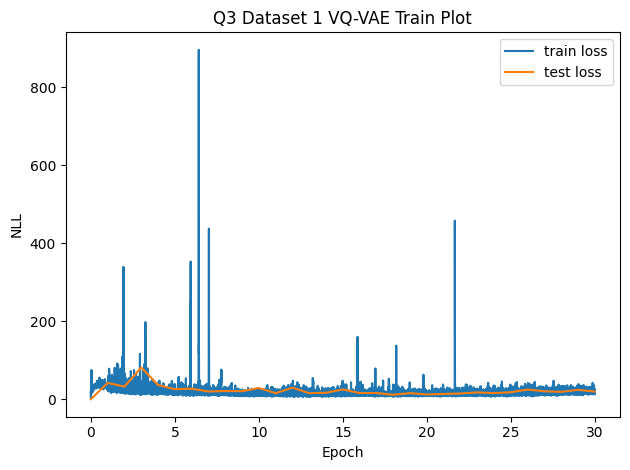

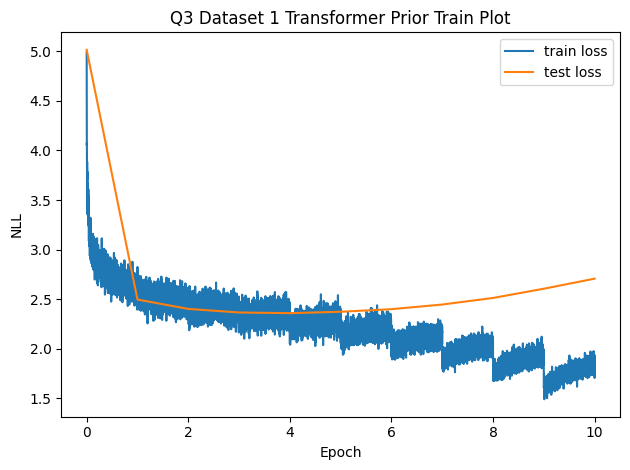

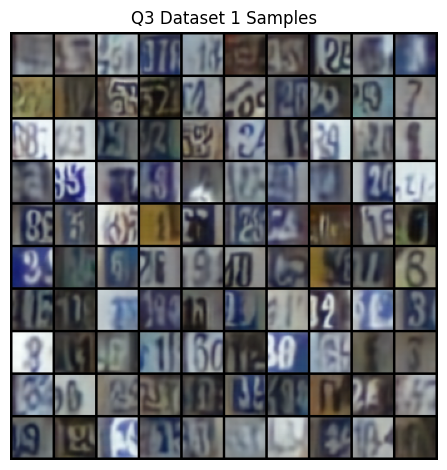

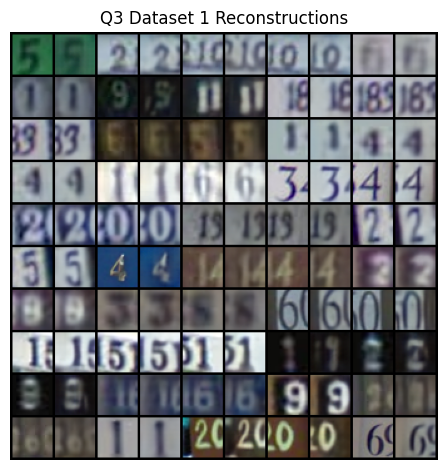

In [25]:
q3_save_results(1, q3)

Training VQ-VAE...
Initial VQ-VAE Test Loss: 0.2964
VQ-VAE Epoch 1/30 - Train Loss: 73.7509, Test Loss: 95.3849
VQ-VAE Epoch 2/30 - Train Loss: 128.5798, Test Loss: 201.0417
VQ-VAE Epoch 3/30 - Train Loss: 142.9863, Test Loss: 104.5597
VQ-VAE Epoch 4/30 - Train Loss: 138.8297, Test Loss: 135.4898
VQ-VAE Epoch 5/30 - Train Loss: 127.5049, Test Loss: 105.8664
VQ-VAE Epoch 6/30 - Train Loss: 126.0850, Test Loss: 115.3145
VQ-VAE Epoch 7/30 - Train Loss: 104.2016, Test Loss: 94.6254
VQ-VAE Epoch 8/30 - Train Loss: 97.3069, Test Loss: 83.5678
VQ-VAE Epoch 9/30 - Train Loss: 97.6006, Test Loss: 92.5972
VQ-VAE Epoch 10/30 - Train Loss: 94.6405, Test Loss: 97.8427
VQ-VAE Epoch 11/30 - Train Loss: 97.3233, Test Loss: 98.9653
VQ-VAE Epoch 12/30 - Train Loss: 101.2698, Test Loss: 94.2401
VQ-VAE Epoch 13/30 - Train Loss: 100.5030, Test Loss: 96.7609
VQ-VAE Epoch 14/30 - Train Loss: 94.5963, Test Loss: 86.3208
VQ-VAE Epoch 15/30 - Train Loss: 93.3011, Test Loss: 84.7688
VQ-VAE Epoch 16/30 - Train Lo

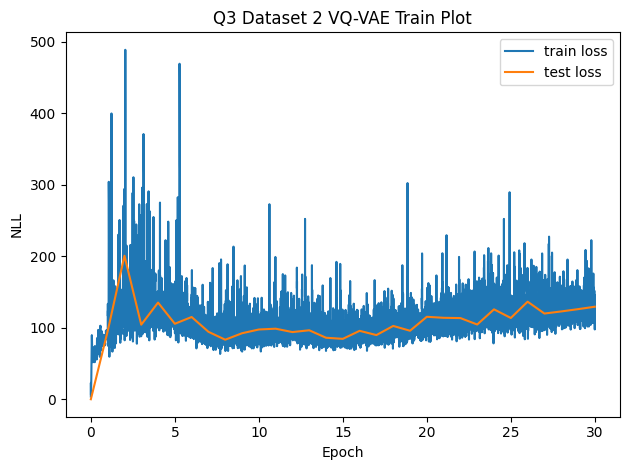

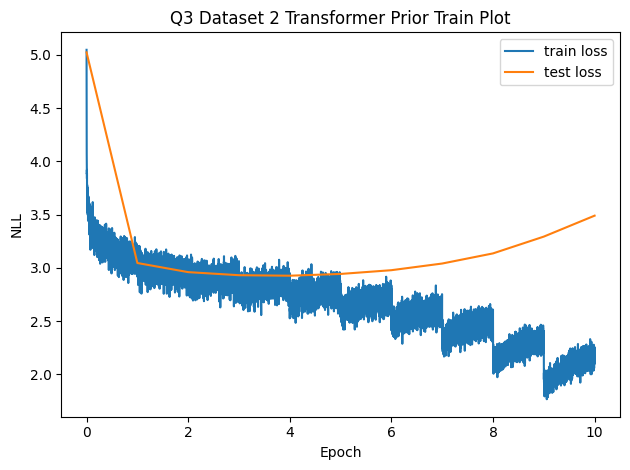

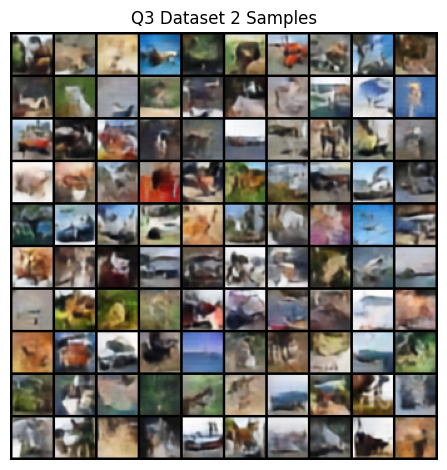

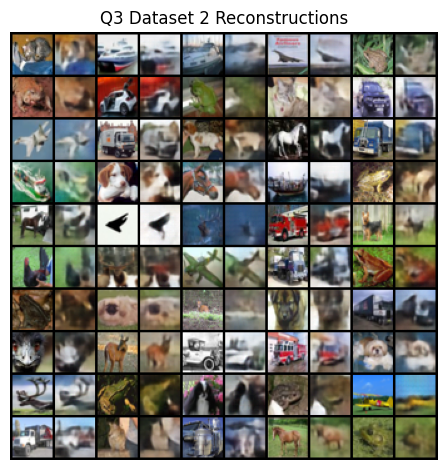

In [26]:
q3_save_results(2, q3)

# File Saving Utility


In [27]:
# # one way to save files
# from google.colab import files
# import os
# import os.path as osp
# for fname in os.listdir('results'):
#     files.download('results/' + fname)

ModuleNotFoundError: No module named 'google'